In [40]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [41]:
def findStability(T, C, hlim, Elim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    E_traj = [TotalEnergy(r0s, v0s, G, masses)]
    
    E0 = np.sum(E_traj[0])
    E0hat = E0 
    
    ## conditions to avoid dividing by zero 
    if E0hat == 0: E0hat = np.max(np.abs(E_traj[0])) 
    if E0hat == 0: E0hat = 1

    E_traj = []
    
    def maxDist(rs):
        d = -1
        n = len(rs)
        for i in range(0,n-1): 
            for j in range(i, n):
                d = max(d, np.linalg.norm(rs[i]-rs[j]))
        return d

    rs, vs = PEFRLStep(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = PEFRLStep(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = PEFRLStep(rs, vs, h_new, G, masses)

        E = TotalEnergy(rs, vs, G, masses) # Calculate Energy 
        relE = np.abs(np.sum(E) - E0) / np.abs(E0hat)

        if h_new < hlim: 
            reason = 2
            break 
        if t+h_new > T: 
            reason =  1
            break 
        if relE > Elim:
            reason = 3
            break 
        if maxDist(rs) > 10:
            reason = 0
            break 
        
        E_traj.append(relE)
        t += h_new
    
    return reason, t, np.max(np.array(relE))

In [42]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [43]:
T = 1000
hlim = 0.01
Elim = 0.01
C = 0.2

In [44]:
def findR(v0s, E0, masses):
    ke = np.sum(KineticEnergy(v0s, masses))
    R = (2 * masses[0] + masses[0] * masses[2] + 2 * masses[2]) / (2 * (ke - E0))
    return R

In [45]:
dm1s = np.linspace(-0.0002,0.0002,200)
dm3s = np.flip(np.linspace(-0.0002, 0.0002,200))

print(dm1s, dm3s)

[-2.00000000e-04 -1.97989950e-04 -1.95979899e-04 -1.93969849e-04
 -1.91959799e-04 -1.89949749e-04 -1.87939698e-04 -1.85929648e-04
 -1.83919598e-04 -1.81909548e-04 -1.79899497e-04 -1.77889447e-04
 -1.75879397e-04 -1.73869347e-04 -1.71859296e-04 -1.69849246e-04
 -1.67839196e-04 -1.65829146e-04 -1.63819095e-04 -1.61809045e-04
 -1.59798995e-04 -1.57788945e-04 -1.55778894e-04 -1.53768844e-04
 -1.51758794e-04 -1.49748744e-04 -1.47738693e-04 -1.45728643e-04
 -1.43718593e-04 -1.41708543e-04 -1.39698492e-04 -1.37688442e-04
 -1.35678392e-04 -1.33668342e-04 -1.31658291e-04 -1.29648241e-04
 -1.27638191e-04 -1.25628141e-04 -1.23618090e-04 -1.21608040e-04
 -1.19597990e-04 -1.17587940e-04 -1.15577889e-04 -1.13567839e-04
 -1.11557789e-04 -1.09547739e-04 -1.07537688e-04 -1.05527638e-04
 -1.03517588e-04 -1.01507538e-04 -9.94974874e-05 -9.74874372e-05
 -9.54773869e-05 -9.34673367e-05 -9.14572864e-05 -8.94472362e-05
 -8.74371859e-05 -8.54271357e-05 -8.34170854e-05 -8.14070352e-05
 -7.93969849e-05 -7.73869

In [46]:
E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities = []
ts = []
Es = []
for dm1 in dm1s:
    for dm3 in dm3s:
        print(dm1, dm3)
        m1hat = m1 + dm1
        m3hat = m3 + dm3

        masseshat = np.array([m1hat, m2, m3hat])

        R = findR(v0s, E0, masseshat)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])

        stability, escapet, maxE = findStability(T, C, hlim, Elim, r0shat, v0s, G, masseshat)

        stabilities.append(stability)
        ts.append(escapet)
        Es.append(maxE)

stabilities = np.array(stabilities).reshape(len(dm1s), len(dm3s))
Es = np.array(stabilities).reshape(len(dm1s), len(dm3s))
ts = np.array(ts).reshape(len(dm1s), len(dm3s))

-0.0002 0.0002
-0.0002 0.00019798994974874369
-0.0002 0.00019597989949748741
-0.0002 0.00019396984924623114
-0.0002 0.00019195979899497487
-0.0002 0.00018994974874371855
-0.0002 0.00018793969849246228
-0.0002 0.000185929648241206
-0.0002 0.00018391959798994974
-0.0002 0.00018190954773869347
-0.0002 0.00017989949748743714
-0.0002 0.00017788944723618087
-0.0002 0.0001758793969849246
-0.0002 0.00017386934673366833
-0.0002 0.00017185929648241206
-0.0002 0.00016984924623115574
-0.0002 0.00016783919597989947
-0.0002 0.0001658291457286432
-0.0002 0.00016381909547738693
-0.0002 0.00016180904522613066
-0.0002 0.00015979899497487433
-0.0002 0.00015778894472361806
-0.0002 0.0001557788944723618
-0.0002 0.00015376884422110552
-0.0002 0.00015175879396984925
-0.0002 0.00014974874371859293
-0.0002 0.00014773869346733666
-0.0002 0.00014572864321608039
-0.0002 0.00014371859296482411
-0.0002 0.00014170854271356784
-0.0002 0.00013969849246231152
-0.0002 0.00013768844221105525
-0.0002 0.0001356783919597989

In [ ]:
import pandas as pd 
df = pd.DataFrame(stabilities)
df.to_csv("Data/Fig8/MassStability.csv")

df = pd.DataFrame(Es)
df.to_csv("Data/Fig8/MassStability_Energy.csv")

df = pd.DataFrame(ts)
df.to_csv("Data/Fig8/MassStability_ts.csv")

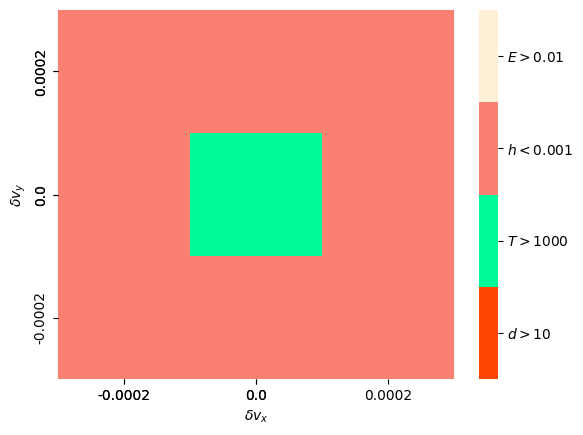

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities.T,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(np.round(dm1s, 5)[tick_positions])
ax.set_yticklabels(np.round(dm3s, 5)[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()
